# Dataset: CK+

# Import all required package

In [22]:
# Import libraries
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
import tensorflow as tf
from keras.utils import np_utils

from keras import backend as K

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator

# Read images from the data path

In [23]:
#Define Datapath
data_path = './ck+'
data_dir_list = os.listdir(data_path)
print(data_dir_list)
img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(981, 48, 48, 3)

# Define the number of classes

In [24]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

# Split dataset

In [25]:
# convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

# Model Building

In [27]:
from tensorflow.keras.applications.vgg19 import VGG19
from keras.layers import Input

vgg = VGG19(weights='imagenet', include_top=False,input_tensor=Input(shape=(img_width, img_height, img_depth)))

In [28]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

input = Input(shape=(48,48,3))

conv = Conv2D(3, kernel_size=(3,3), padding='same')(input)

vgg = vgg(conv)
    
x = Flatten()(vgg)

pred = Dense(7, activation='softmax')(x)

model = Model(inputs=input, outputs=pred)

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 3)         84        
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 20,028,059
Trainable params: 20,028,059
Non-trainable params: 0
_________________________________________________________________


In [30]:
#EVALUATION

import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [31]:
#EVALUATION

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [32]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=METRICS
)

In [33]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


training_data = train_datagen.flow(X_train,y_train,batch_size = 16)

In [34]:
from keras import callbacks
filepath="Best1.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(training_data, epochs=30,callbacks=callbacks_list, validation_data=(X_test,y_test))


Epoch 1/30
49/49 [==============================] - 4s 52ms/step - loss: 0.8838 - accuracy: 0.9442 - precision: 0.8178 - recall: 0.7844 - auc: 0.8949 - f1_score: 0.7844 - val_loss: 0.9403 - val_accuracy: 0.9405 - val_precision: 0.7919 - val_recall: 0.7919 - val_auc: 0.9109 - val_f1_score: 0.7687
Epoch 2/30
49/49 [==============================] - 2s 45ms/step - loss: 0.8262 - accuracy: 0.9462 - precision: 0.8123 - recall: 0.8112 - auc: 0.9040 - f1_score: 0.8117 - val_loss: 0.8612 - val_accuracy: 0.9405 - val_precision: 0.7919 - val_recall: 0.7919 - val_auc: 0.9156 - val_f1_score: 0.7687
Epoch 3/30
49/49 [==============================] - 2s 45ms/step - loss: 0.7801 - accuracy: 0.9464 - precision: 0.8125 - recall: 0.8125 - auc: 0.9263 - f1_score: 0.8125 - val_loss: 0.7691 - val_accuracy: 0.9398 - val_precision: 0.7908 - val_recall: 0.7868 - val_auc: 0.9534 - val_f1_score: 0.7663
Epoch 4/30
49/49 [==============================] - 2s 45ms/step - loss: 0.7724 - accuracy: 0.9442 - precisio

# Qualitative Results

Test Loss: 0.49391987919807434
Test accuracy: 0.9601160287857056
(1, 48, 48, 3)
1/1 [==============================] - 0s 117ms/step
[[0.24593616 0.09163968 0.16269843 0.27547437 0.04341955 0.01354476
  0.16728707]]
1/1 [==============================] - 0s 16ms/step
[[0. 0. 0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 19ms/step


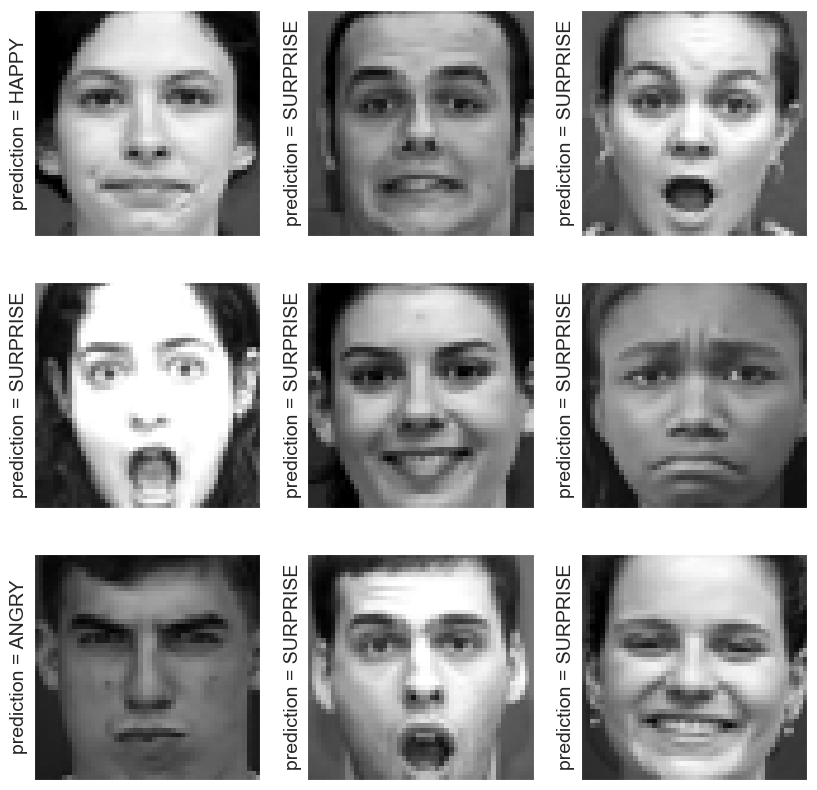

In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
classes_x = np.argmax(model.predict(test_image),axis=1)
print(y_test[0:1])

res = np.argmax(model.predict(X_test[0:9]),axis=1)
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap = plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
    
# show the plot
plt.show()

# Quantitative Results

In [36]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

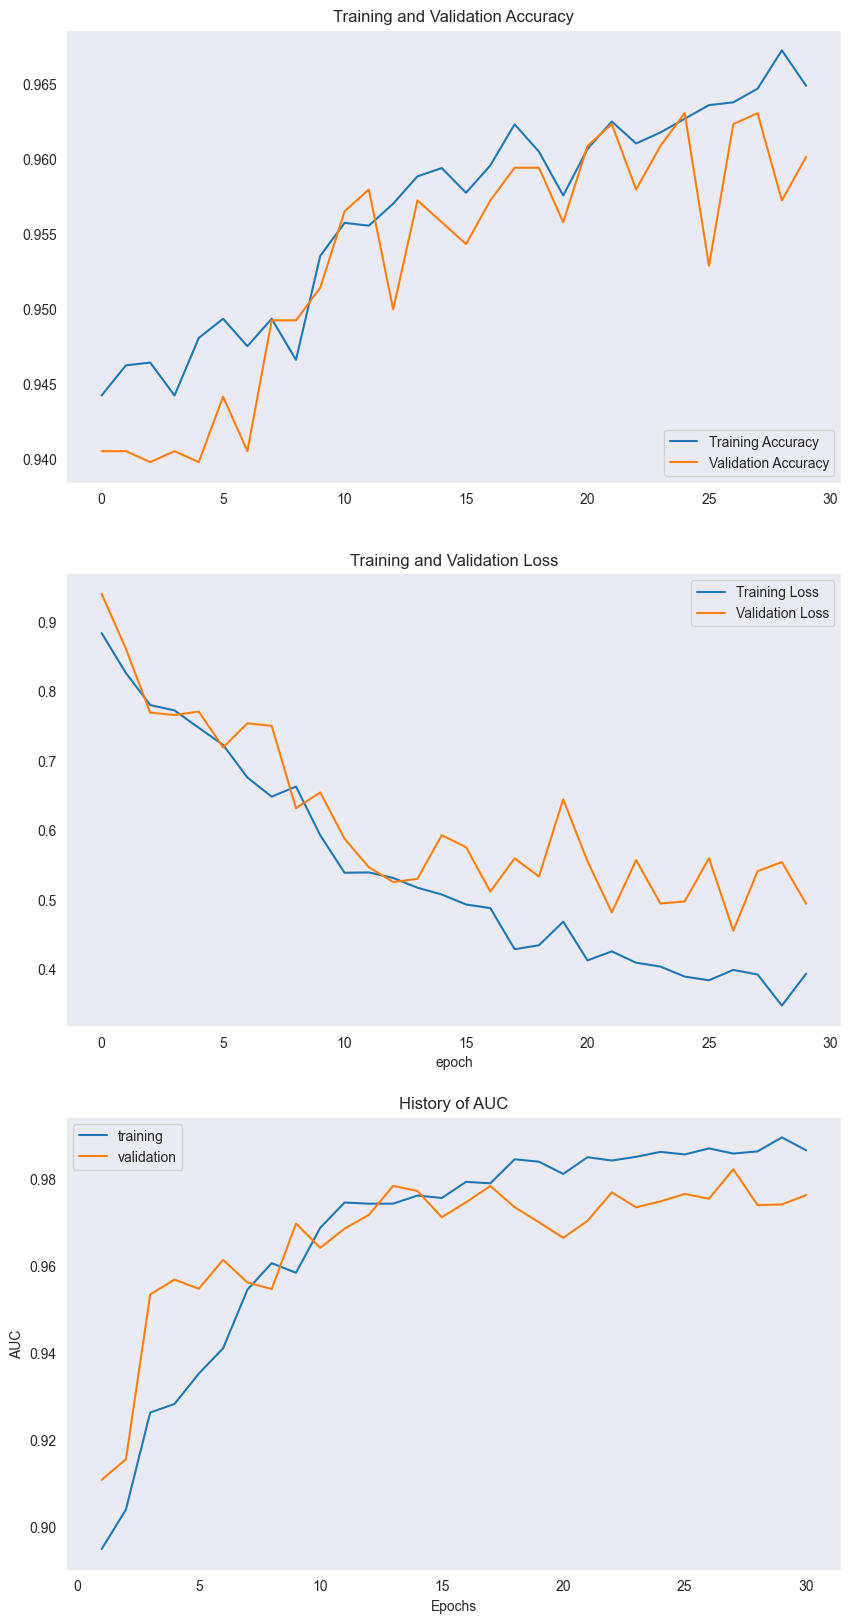

In [37]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()

In [38]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.96
Train Loss:  0.39
Train Precision:  0.93
Train Recall:  0.81
Train F1-Score:  0.87


In [39]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.96
Test Loss:  0.49
Test Precision:  0.9
Test Recall:  0.81
Test F1-Score:  0.85


# Confusion Matrix

In [40]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

7/7 [==============================] - 0s 43ms/step


In [41]:
# evaluate model on test set
acc = model.evaluate(X_test,y_test)
print ("model %s: %.2f%%" % (model.metrics_names[1], acc[1]*100))

7/7 [==============================] - 0s 17ms/step - loss: 0.4939 - accuracy: 0.9601 - precision: 0.8989 - recall: 0.8122 - auc: 0.9763 - f1_score: 0.8466
model accuracy: 96.01%


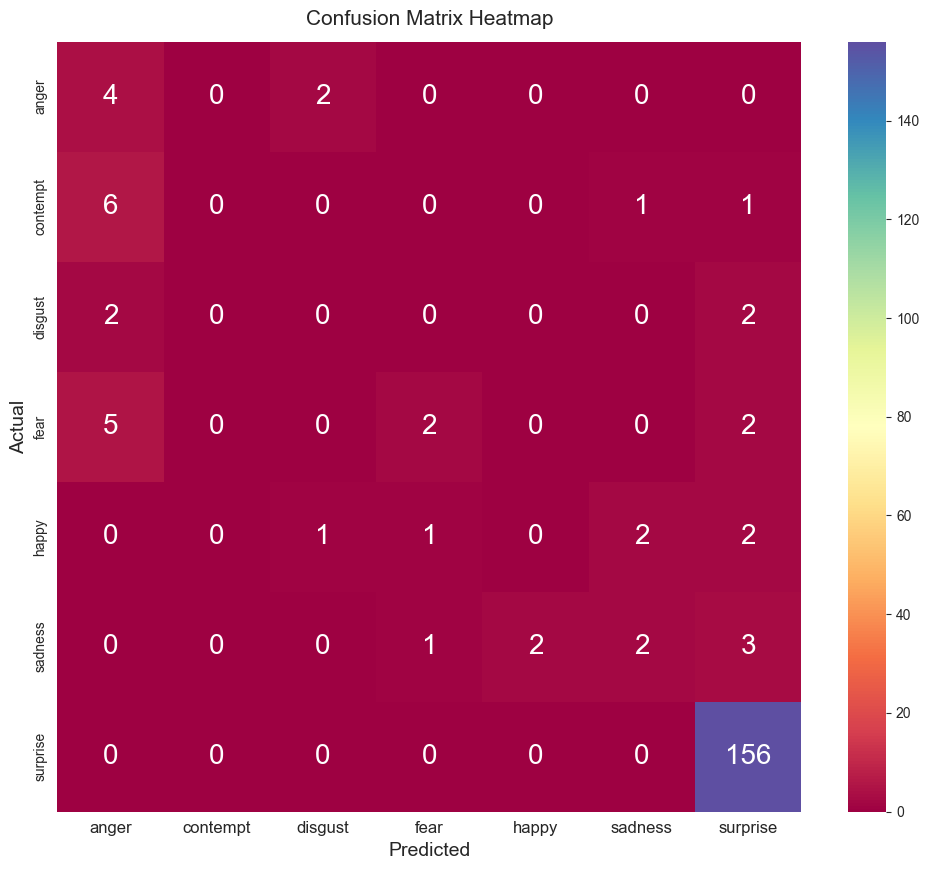

In [42]:
conf_mat = confusion_matrix(np.where(y_test == 1)[1],Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['anger','contempt','disgust','fear','happy','sadness','surprise'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['anger','contempt','disgust','fear','happy','sadness','surprise'], fontdict={'fontsize':10})
plt.show()